# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

This is a step by step algorithm implemented to train and test a traffic sign classifier. The Neural Network is based on the LeNet model. The writep document with more in depth explanations can be found on my [GitHub page](https://github.com/gabrielvivan/AVs)

## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = '../data/train.p'
validation_file = '../data/valid.p'
testing_file = '../data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Dataset summary display
print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_valid)))
print("Test Set:       {} samples".format(len(X_test)))


Image Shape: (32, 32, 3)

Training Set:   34799 samples
Validation Set: 4410 samples
Test Set:       12630 samples


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


### Basic Summary of the Data Set

In [2]:
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = max(y_train) + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled files.
Here I show an example of what the images look like in the training data, and I display a histogram portraying the number of images per class in the training, validation, and testing data.
As seen, the initial classes have many more images than the later classes. Maybe this means that the machine will be able to more accurately recognize traffic sings belonging to these classes.

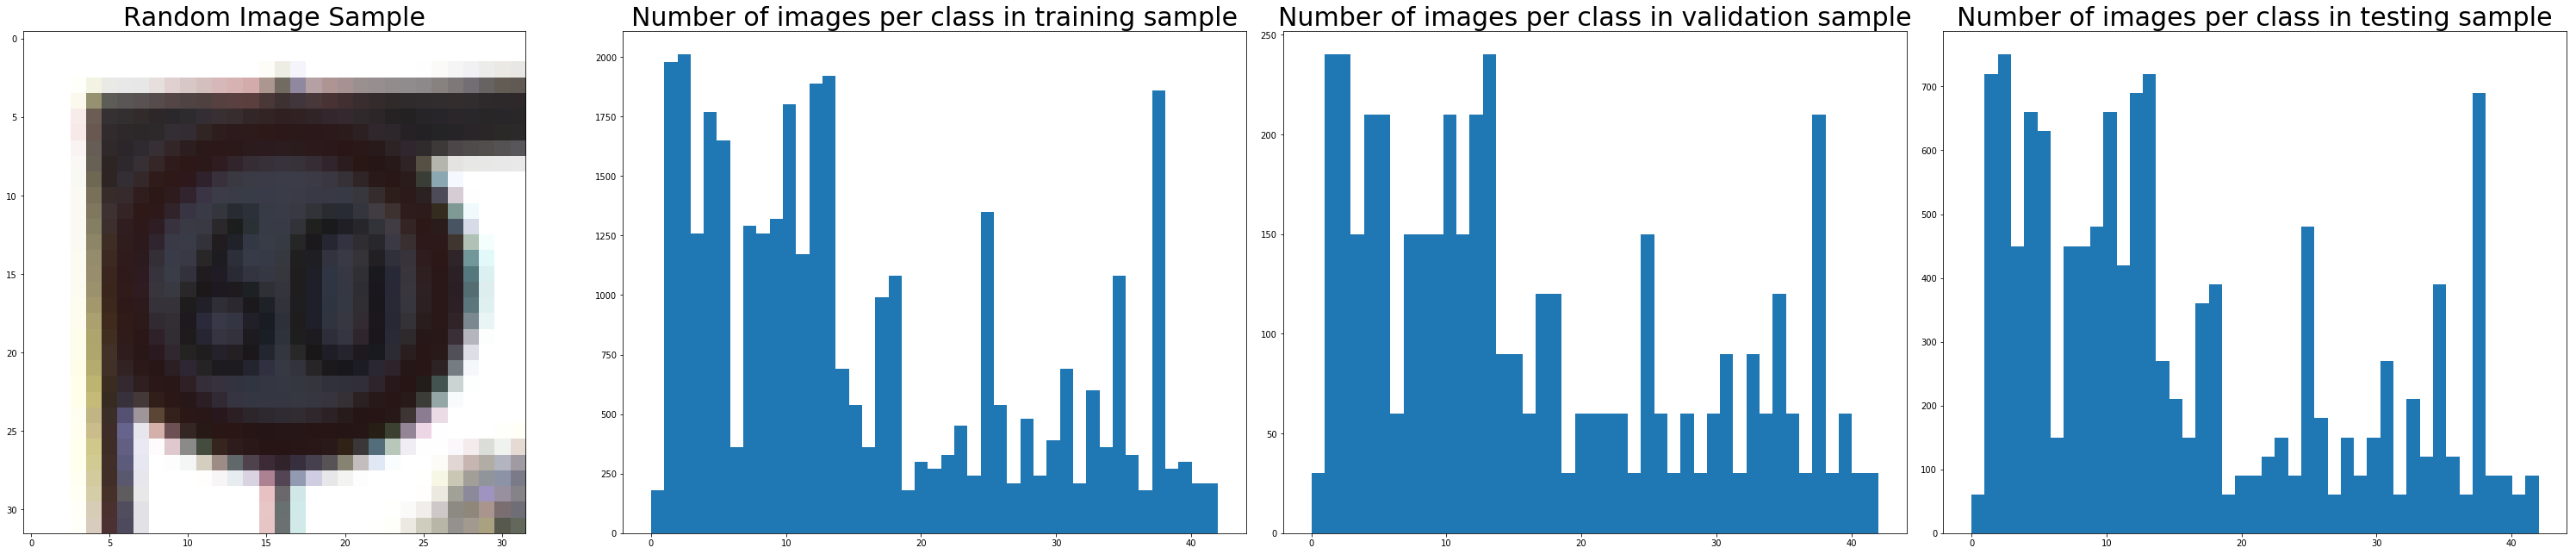

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Pick a random image from training data to display
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

# Display images
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(42, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Random Image Sample', fontsize=30)

ax2.hist(y_train, bins=n_classes)
ax2.set_title('Number of images per class in training sample', fontsize=30)

ax3.hist(y_valid, bins=n_classes)
ax3.set_title('Number of images per class in validation sample', fontsize=30)

ax4.hist(y_test, bins=n_classes)
ax4.set_title('Number of images per class in testing sample', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).


### Pre-process the Data Set (normalization, grayscale)

All datasets are converted to grayscale images, so that colors are not taken into account by the algorithm. Then, the datasets are normalized using function `normalize` from `sklearn`

In [4]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.

from sklearn.utils import shuffle
from sklearn import preprocessing
import cv2

def preprocess(X_train):
    X_train_grayscale = np.zeros(X_train.shape[:-1])
    X_train_preprocessed = np.zeros(X_train.shape[:-1])
    for i in range(X_train.shape[0]): 
        X_train_grayscale[i] = cv2.cvtColor(X_train[i], cv2.COLOR_RGB2GRAY) 
        X_train_preprocessed[i] = preprocessing.normalize(X_train_grayscale[i], norm='l2')
    X_train_preprocessed = X_train_preprocessed.reshape(len(X_train),32,32,1)
    return X_train_preprocessed

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 1)


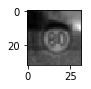

In [5]:
# Preprocess all input data
X_train = preprocess(X_train)
X_valid = preprocess(X_valid)
X_test = preprocess(X_test)

# Shuffle training data to avoid initial bias
X_train, y_train = shuffle(X_train, y_train)

# Check if data is still accurate and in grayscale
print("Number of training examples =", len(X_train))
print("Number of testing examples =", len(X_test))
print("Image data shape =", X_train[0].shape)

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()
plt.figure(figsize=(1,1))
plt.imshow(image, cmap='gray')

### Model Architecture

Very similar to the LeNet architecture, with the addition of dropout

In [6]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

EPOCHS = 10
BATCH_SIZE = 128

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 26x26x13.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(7, 7, 1, 13), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(13))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation and dropout
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.dropout(conv1, keep_prob)

    # Pooling. Input = 26x26x13. Output = 13x13x13.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Input = 13x13x13. Output = 10x10x26.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(4, 4, 13, 26), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(26))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation and dropout
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.dropout(conv2, keep_prob)

    # Pooling. Input = 10x10x26. Output = 5x5x26.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x26. Output = 650.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 650. Output = 300.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(650, 300), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(300))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation and dropout
    fc1    = tf.nn.relu(fc1)
    fc1    = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 300. Output = 86.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(300, 86), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(86))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation and dropout
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 86. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(86, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Features and Labels

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.
`keep_prob` is a placeholder for the dropout rate.

In [7]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

### Set up training and validation pipelines

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [8]:
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.

# Set a learning rate
rate = 0.0008

# Training pipeline
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

# Evaluation pipeline
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x,
                                                           y: batch_y,
                                                           keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

In [9]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, 
                                                    y: batch_y,
                                                    keep_prob: 0.60})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.716

EPOCH 2 ...
Validation Accuracy = 0.820

EPOCH 3 ...
Validation Accuracy = 0.859

EPOCH 4 ...
Validation Accuracy = 0.893

EPOCH 5 ...
Validation Accuracy = 0.904

EPOCH 6 ...
Validation Accuracy = 0.906

EPOCH 7 ...
Validation Accuracy = 0.922

EPOCH 8 ...
Validation Accuracy = 0.929

EPOCH 9 ...
Validation Accuracy = 0.935

EPOCH 10 ...
Validation Accuracy = 0.942

Model saved


### Evaluate the model with test data

In [10]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.915


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

### Load and Output the Images

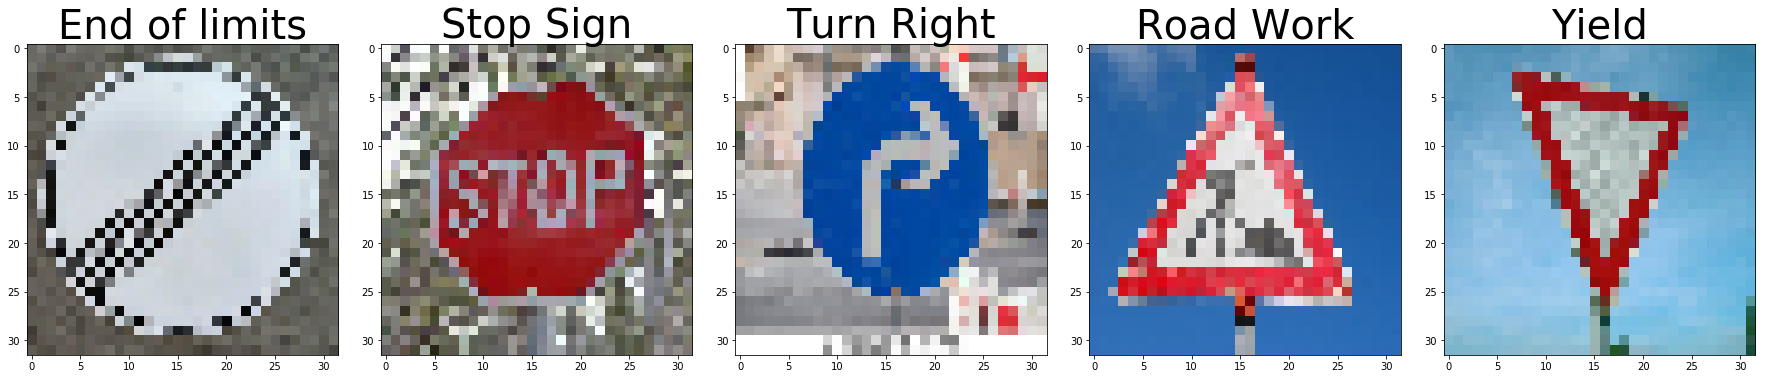

In [9]:
# Load the images and plot them here.

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def test_images_resize(img):
    dsize = (32,32)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,dsize)
    return img

test1 = cv2.imread('../data/end_limits.jpg')
test1 = test_images_resize(test1)

test2 = cv2.imread('../data/STOP_sign.jpg')
test2 = test_images_resize(test2)

test3 = cv2.imread('../data/turn_right.jpg')
test3 = test_images_resize(test3)

test4 = cv2.imread('../data/road_work.jpg')
test4 = test_images_resize(test4)

test5 = cv2.imread('../data/yield.jpg')
test5 = test_images_resize(test5)

# Display original and undistorted test image
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(24, 9))
f.tight_layout()

ax1.imshow(test1)
ax1.set_title('End of limits', fontsize=40)

ax2.imshow(test2)
ax2.set_title('Stop Sign', fontsize=40)

ax3.imshow(test3)
ax3.set_title('Turn Right', fontsize=40)

ax4.imshow(test4)
ax4.set_title('Road Work', fontsize=40)

ax5.imshow(test5)
ax5.set_title('Yield', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Preprocess images

Here I preprocess the downloaded images in the same way as done with the training data, and I verify if the shape is correct

Number of examples = 5
Image data shape = (32, 32, 1)


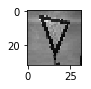

In [10]:
X_real = np.array([test1,test2,test3,test4,test5])
X_real = preprocess(X_real)
y_real = np.array([32,14,33,25,13])
num_examples = len(X_real)

# Check if data is still accurate and in grayscale
print("Number of examples =", num_examples)
print("Image data shape =", X_real[0].shape)

image = X_real[4].squeeze()
plt.figure(figsize=(1,1))
plt.imshow(image, cmap='gray')

### Predictions

Here I display what are the class IDs and predictions for each image

In [11]:
import pandas

prediction = tf.argmax(logits, 1)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_real[offset:end], y_real[offset:end]
            result = sess.run(prediction, feed_dict={x: batch_x,
                                                     y: batch_y,
                                                     keep_prob: 1})
    
print('Class IDs result:', result)

traffic_signs = pandas.read_csv('./signnames.csv')
print()
print('Traffic signs recognized, in order:')
for i in range(len(result)):
    print(traffic_signs.SignName[result[i]])

INFO:tensorflow:Restoring parameters from ./lenet
Class IDs result: [32 14 33 25 13]

Traffic signs recognized, in order:
End of all speed and passing limits
Stop
Turn right ahead
Road work
Yield


### Analyze Performance

Here I evaluate the accuracy of the model on the downloaded images

In [12]:
# Calculate the accuracy for these 5 new images. 

import tensorflow as tf

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_real, y_real)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 1.000


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

Using softmax function and top_k, from tensorflow

In [13]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

k = 5
softmax = tf.nn.softmax(logits)
topk = tf.nn.top_k(softmax, k)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_real[offset:end], y_real[offset:end]
            probs = sess.run(topk, feed_dict={x: batch_x,
                                              y: batch_y,
                                              keep_prob: 1})
    
print()
print('Top 5 class IDs of each image, and their probabilities:')
print()
print(probs)

INFO:tensorflow:Restoring parameters from ./lenet

Top 5 class IDs of each image, and their probabilities:

TopKV2(values=array([[ 0.53716069,  0.23423804,  0.1707072 ,  0.00877583,  0.00855243],
       [ 0.79835284,  0.09576952,  0.05139446,  0.01757391,  0.00877271],
       [ 0.89358169,  0.02608262,  0.01490678,  0.0142068 ,  0.0124208 ],
       [ 0.2914581 ,  0.20686449,  0.09259433,  0.09133696,  0.03328601],
       [ 0.94846249,  0.01172109,  0.00734846,  0.00524677,  0.00368094]], dtype=float32), indices=array([[32, 41,  6, 28, 42],
       [14, 38, 34, 17, 12],
       [33, 39, 37, 18, 13],
       [25, 31, 19, 21, 33],
       [13, 35, 11, 37, 12]], dtype=int32))


### Project Writeup

The writep document with more in depth explanations can be found on my [GitHub page](https://github.com/gabrielvivan/AVs)